## Linear Regression Model for S&P 500 Closing Prices

The purpose of this project is to create a model to predict the closing price for the S&P 500 index on the following day.  We will be using data that contains information about the index from 1/3/1950 to 12/7/2015. In this project, we will be using a linear regression model. The data we are using is located __[here](https://raw.githubusercontent.com/NickyThreeNames/DataquestGuidedProjects/master/Guided%20Project-%20Predicting%20the%20stock%20market/sphist.csv)__ from GitHub user NickyThreeNames. This data contains the open, high, low and closing price for the __[S&P 500 index](https://en.wikipedia.org/wiki/S%26P_500_Index)__ as well as the date these prices occurred and the __[volume](https://en.wikipedia.org/wiki/Volume_(finance))__ for the day. We will be evaluating our model in terms of being useful for a stock trader trading the S&P 500 index.

First, we will get our data and take a quick look into it.

In [194]:
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from pandas.plotting import register_matplotlib_converters

stocks = pd.read_csv('https://raw.githubusercontent.com/NickyThreeNames/DataquestGuidedProjects/master/Guided%20Project-%20Predicting%20the%20stock%20market/sphist.csv')

print(stocks.info())
stocks.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16590 entries, 0 to 16589
Data columns (total 7 columns):
Date         16590 non-null object
Open         16590 non-null float64
High         16590 non-null float64
Low          16590 non-null float64
Close        16590 non-null float64
Volume       16590 non-null float64
Adj Close    16590 non-null float64
dtypes: float64(6), object(1)
memory usage: 907.4+ KB
None


,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883


In [195]:
stocks.tail()

,Date,Open,High,Low,Close,Volume,Adj Close
16585,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08
16586,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
16587,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
16588,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
16589,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66


### Data Cleaning

This data is very clean. There are only a couple things we need to do in order to get it into the form we would like. The first column of our data frame contains dates. We will convert these to datetime objects in order to use them in our model and apply mathematical functions to them. We also notice that the dates are in descending order. We would like the rows with the lower indices to have the earliest date. Therefore, after we change the dates to datetime objects, we will reverse the order of the data frame and then re-index it, making it easier to deal with for manipulation and modelling.

In [196]:
#converting dates
stocks['Date'] = pd.to_datetime(stocks['Date'])

#sorting DF by date earliest to most recent
stocks = stocks.sort_values(by=['Date'], ascending=True)
stocks = stocks.reset_index()
stocks.head()

,index,Date,Open,High,Low,Close,Volume,Adj Close
0,16589,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
1,16588,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
2,16587,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
3,16586,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
4,16585,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


### Feature Engineering

Our goal is to predict the closing price for the next day of trading for the S&P 500 index. In order to accomplish, we are creating new columns to use as our features. We will be using a combination of price averages, rate of change ratios and volume ratios. Volume will be included as periods of higher trading activity represented by volume typically have a __[correlation](https://www.investtech.com/main/market.php?CountryID=44&p=staticPage&fn=helpItem&tbReport=h_PVC)__ to price movement. We will create:

-  `day_5_avg`, previous week's average closing price
-  `day_30_avg`, previous month's average closing price 
-  `std_5_to_365`, ratio of the standard deviation of the closing price for previous week to previous year
-  `vol_5_to_365`, ratio of average volume for previous week to previous year

Since we are using ratios that need at least a year of trading data, we will fill our new feature columns with zeros for any rows with `Date` prior to 1/3/1951.

In [197]:
#creating 4 functions for model
for index, row in stocks.iterrows():
#filling in with zeros for dates we can't completetly calculate yet
    if stocks.loc[index, 'Date'] < datetime(year=1951, month=1, day=3):
        stocks.loc[index, 'day_5_avg'] = 0
        stocks.loc[index, 'day_30_avg'] = 0
        stocks.loc[index, 'std_5_to_365'] = 0
        stocks.loc[index, 'vol_5_to_365'] = 0
        
    else:
        #5 day average
        stocks.loc[index, 'day_5_avg'] = stocks['Close'].loc[(index-5):(index-1)].mean()
            
            
        #30 day average
        month_ago = stocks['Date'][index] - timedelta(days = 30)
        month_ago_index = stocks[stocks['Date'] >= month_ago].index[0]
        
        stocks.loc[index, 'day_30_avg'] = stocks['Close'].loc[(month_ago_index):(index-1)].mean()
            
        #5 day std. dev. to 365 std. dev ratio
        day_5_std = stocks['Close'].loc[(index-5):(index-1)].std()
        
        year_ago = stocks['Date'][index] - timedelta(days = 365)
        year_ago_index = stocks[stocks['Date'] >= year_ago].index[0]
        day_365_std = stocks['Close'].loc[(year_ago_index):(index-1)].std()
        
        stocks.loc[index, 'std_5_to_365'] = day_5_std / day_365_std
            
        #5 day average volume vs. 365 day avg. Volume
        day_5_vol = stocks['Volume'].loc[(index-5):(index-1)].mean()
        year_avg_vol = stocks['Volume'].loc[(year_ago_index):(index-1)].mean()
        
        stocks.loc[index, 'vol_5_to_365'] = day_5_vol / year_avg_vol

Now that we have our features calculated, we will use them to create a model for predicting the next day's S&P 500 closing price. We will use a linear regression model from __[Scikit-learn](https://en.wikipedia.org/wiki/Scikit-learn)__. The _training_ data will be all the S&P 500 price information from the first day we can calculate all our features, 1/3/1951 up to the trading day just prior to the day we are predicting. The _test_ data will be the day for which we are making our prediction. In addition to running the model we will also calculate the RMSE and create some lists in order to evaluate how well the model performs.

In [198]:
#getting df with all feature columns filled
stocks_filled = stocks[stocks['Date'] > datetime(year=1951, month=1, day=2)]
stocks_filled = stocks_filled.dropna(axis=0)
drop_train_cols = stocks_filled.drop(['index','Close', 'High', 'Low', 'Open', 'Volume', 'Adj Close', 'Date'], axis='columns')
features = drop_train_cols.columns 
    
first_day_test_index = stocks_filled[stocks_filled['Date'] >= datetime(year=2013, month=1, day=1)].index[0]
last_day_test_index =  stocks_filled.index[-1]

#instantiating lists for model performance evluation
avg_rmse, percent_miss, test_dates, actual_close, predicted_close, move = ([] for i in range(6))

#counter for checking if prediction inside of days trading range
in_range_count = 0
    
for i in range (first_day_test_index, (last_day_test_index + 1)):   
    train = stocks_filled[stocks_filled['Date'] < stocks_filled['Date'][i]]
    
    test = stocks_filled[stocks_filled['Date'] == stocks_filled['Date'][i]]
    
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train['Close'])
    predictions = lr.predict(test[features])
    
    #calculating RMSE
    mse = mean_squared_error(test['Close'], predictions)
    rmse = np.sqrt(mse)
    avg_rmse.append(rmse)
    
    # list of predictions
    predicted_close.append(predictions[0])
    
    # date list
    test_dates.append(test['Date'][i])
    
    #list of target/actual closing price 
    actual_close.append(test['Close'][i])
    
    
    #percent error model missed target
    prcnt_off = (abs(test['Close'][i] - predictions) / test['Close'][i]) * 100
    percent_miss.append(prcnt_off)
    
    #check if prediction occured in price range of trading day
    if (predictions[0] >= stocks_filled['Low'][i] and predictions <= stocks_filled['High'][i]):
        in_range_count += 1
        
print('Our prediction RMSE from 1/1/13 to 12/7/15 (739 trading days) is:', (round(np.mean(avg_rmse), 2)), '\n')
print('Highest RMSE:', round(max(avg_rmse), 2), 'Lowest RMSE:', round(min(avg_rmse), 2), '\n')
print('Number of times prediction RMSE was less than or equal to 1:', sum(1 for i in avg_rmse  if i <= 1), '\n')
print('Our average percentage we missed our target by from 1/1/13 to 12/7/15 (739 trading days) is:', (round(np.mean(percent_miss), 2)), '\n')
print('Number of times our prediction was off by less than or equal to 1%:', sum(1 for i in percent_miss  if i <= 1), '\n')
print('The number of times our prediction was in the daily range of the S&P 500:', in_range_count, '\n')

Our prediction RMSE from 1/1/13 to 12/7/15 (739 trading days) is: 16.01 

Highest RMSE: 161.17 Lowest RMSE: 0.03 

Number of times prediction RMSE was less than or equal to 1: 27 

Our average percentage we missed our target by from 1/1/13 to 12/7/15 (739 trading days) is: 0.85 

Number of times our prediction was off by less than or equal to 1%: 512 

The number of times our prediction was in the daily range of the S&P 500: 286 



### Evaluating Model Performance

We see above, some different performance metrics to help determine the viability of our model. The model showed a mean RMSE of 16.01 on our test data. There was quite a range in our RMSE values, as the minimum was near zero and the highest value was almost 10 times the mean. Our model was very close (RMSE < 1) to the target a mere 3.5% of the time. In terms of percentage miss, the model did fairly well keeping the average miss less than 1% and achieving a miss of less than 1% about 69% of the time. In a trading system we would also be interested to see if our predicted target was hit at any time of the day. The model managed to have it's predicted price hit during the trading day about 39% of the time on the test data.

These numbers give us some of the story. Let's take a look at how our model did graphically. below we will plot the actual closing price of the S&P 500 and compare it to our predicted price.

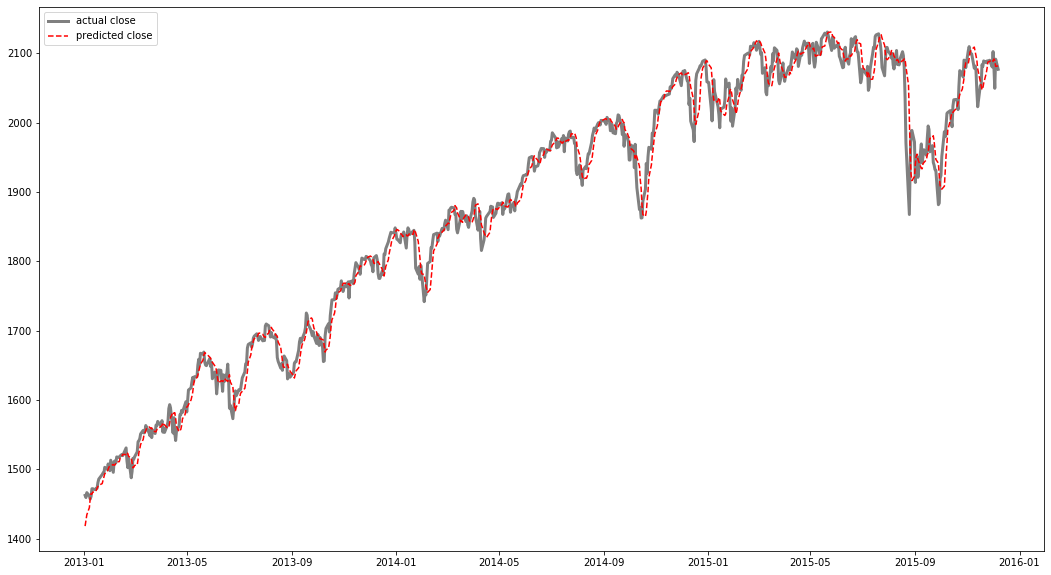

In [199]:
fig = plt.figure(figsize =(18,10))
ax1 = fig.add_subplot(111)

#actual closing price
ax1.plot(test_dates, actual_close, c='grey', label ='actual close', lw=3)

#predicted closing price
ax1.plot(test_dates, predicted_close, c='r', label = 'predicted close', ls = 'dashed')

plt.legend(loc='upper left')
plt.show()

We can observe a few characteristics of our model in the above graph. We can see that the model seems to trail the actual closing price. When the S&P 500 is in an uptrend our model tends to predict the price too low. Conversely, in a downtrend the model tends to predict the price above the actual close. As we would expect from a linear regression model, our model performs the worst when there is rapid price movement. Given that the model has the lowest prediction error near when the market appears to be changing course, one possible use for the model could be in finding a reversal of the current market trend. 

Below, we will take a closer look into when our model predicts very close (within 1 of actual closing price), predicts above target, and predicts below target. This will give us a better picture as to the effectiveness of our model at identifying trend reversals. We will also show the percentage error our model missed its target to further our understanding of this model's performance.

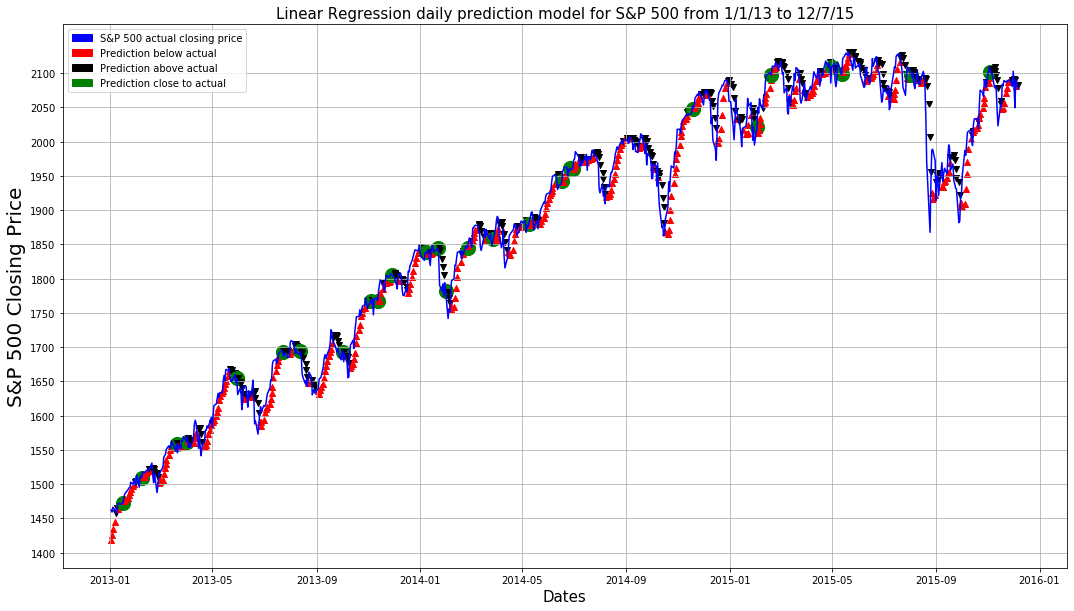

In [200]:
fig = plt.figure(figsize =(18,10))
ax1 = fig.add_subplot(111)


#colors for legend
red_patch = mpatches.Patch(color='red', label = 'Prediction below actual')
black_patch = mpatches.Patch(color='black', label = 'Prediction above actual')
green_patch =  mpatches.Patch(color='green', label='Prediction close to actual')
blue_patch = mpatches.Patch(color='blue', label = 'S&P 500 actual closing price')

#plotting of actual vs. predicted price
ax1.plot(test_dates,actual_close, c='blue')
for i in range(0, 739):
    
    #predicted above target
    if abs(predicted_close[i] - actual_close[i]) > 1 and (predicted_close[i] - actual_close[i]) < 0:
        ax1.scatter(test_dates[i], predicted_close[i], marker ='^', c='red')
        
    #predicted below target    
    if (predicted_close[i] - actual_close[i]) > 1:
        ax1.scatter(test_dates[i], predicted_close[i], marker = 'v', c='black')
        
    #predicted very close to target
    elif abs(actual_close[i] - predicted_close[i]) <= 1:
        ax1.scatter(test_dates[i], predicted_close[i], s=200, c='green')
             
plt.yticks(range(1400, 2150, 50))
plt.grid()
plt.xlabel('Dates', fontsize = 15)
plt.ylabel('S&P 500 Closing Price', fontsize = 20)
plt.title('Linear Regression daily prediction model for S&P 500 from 1/1/13 to 12/7/15', fontsize = 15)
plt.legend(handles =[blue_patch, red_patch, black_patch, green_patch],loc='upper left')
plt.show()

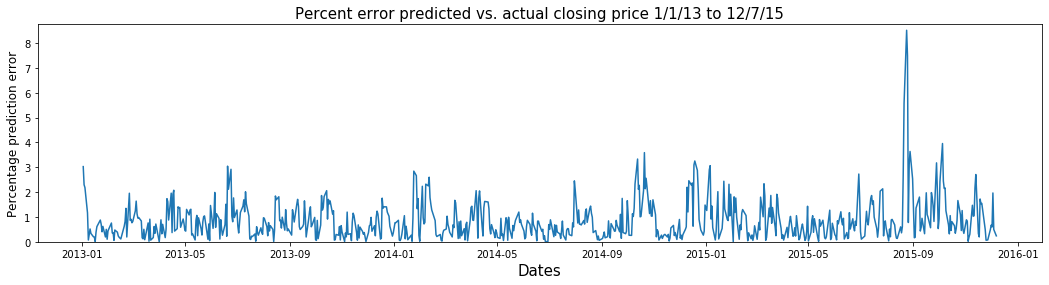

In [201]:
fig = plt.figure(figsize = (18, 4))
plt.ylim(0, 8.75)
plt.xlabel('Dates', fontsize = 15)
plt.ylabel('Percentage prediction error', fontsize = 12)
plt.title('Percent error predicted vs. actual closing price 1/1/13 to 12/7/15', fontsize = 15)
plt.plot(test_dates, percent_miss)

We can see a direct correlation between the increase in our predicted error to an increase in the rate of change in closing price. Given that we are using a linear regression model, we would expect this. Linear regression does not do well in precisely predicting targets with big variance. This model does well when there is sideways movement in the closing price for the S&P 500. This is only useful if a trader uses selling options as part of their trading strategy. Most traders want big swings in prices, which is when they can make greater profits.

Below, we will examine this a bit closer. The following examines two distinctly different time periods. We will examine from 1/1/13 to 4/25/14 which is a fairly consistent uptrend with lower volatility. The second represents a period of higher volatilty from 4/28/14 to 12/7/15. It should be noted that 4/26/14 and 4/27/14 were weekend days.

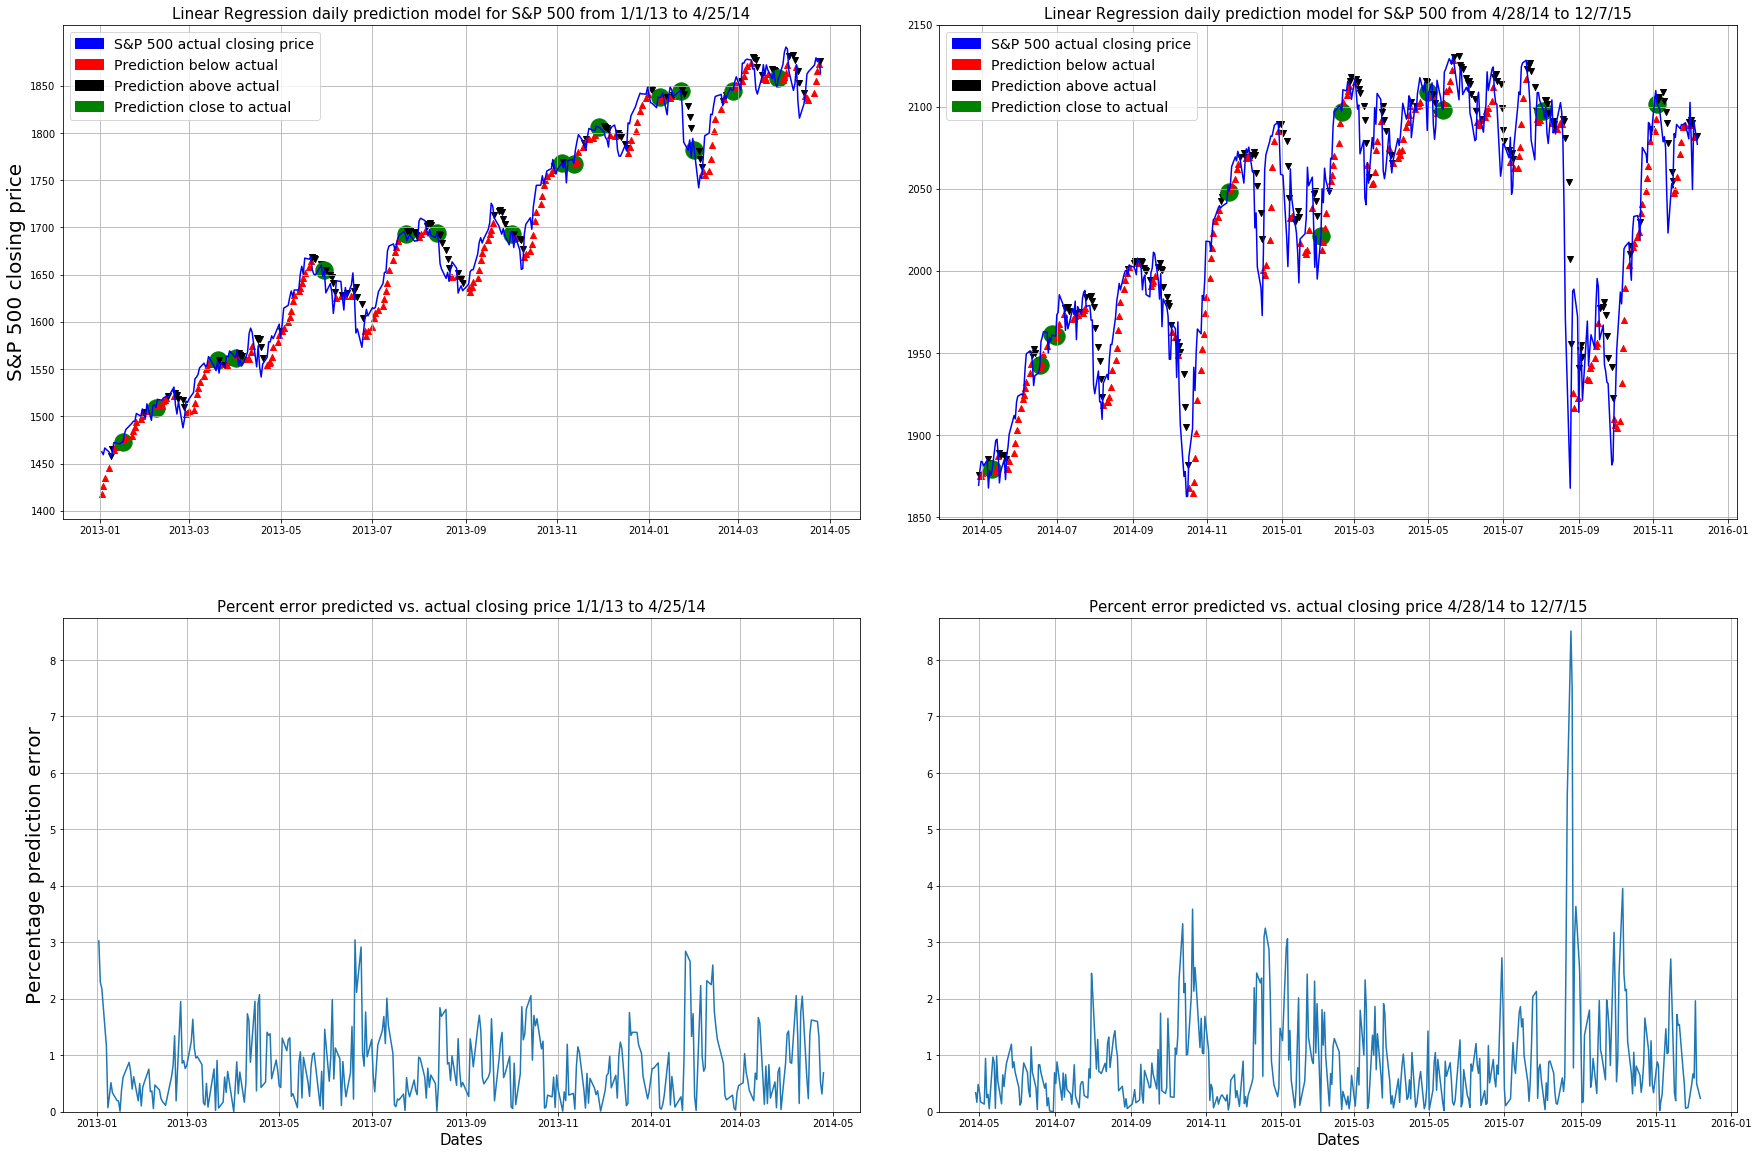

In [202]:
fig, axes = plt.subplots(nrows = 2, ncols=2, figsize=(30,20))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(wspace =.1, hspace = .2)


#colors for legend
red_patch = mpatches.Patch(color='red', label = 'Prediction below actual')
black_patch = mpatches.Patch(color='black', label = 'Prediction above actual')
green_patch =  mpatches.Patch(color='green', label='Prediction close to actual')
blue_patch = mpatches.Patch(color='blue', label = 'S&P 500 actual closing price')

#plotting upper left, first set of actual vs. predicted 1/1/13 to 4/25/14
ax1.plot(test_dates[:331],actual_close[:331], c='blue')
for i in range(0, 331):
    if abs(predicted_close[i] - actual_close[i]) > 1 and (predicted_close[i] - actual_close[i]) < 0:
        ax1.scatter(test_dates[i], predicted_close[i], marker = '^', c='red')
    if (predicted_close[i] - actual_close[i]) > 1:
        ax1.scatter(test_dates[i], predicted_close[i], marker = 'v', c='black')
    elif abs(actual_close[i] - predicted_close[i]) <= 1:
        ax1.scatter(test_dates[i], predicted_close[i], s=300, c='green')

ax1.set_yticks(range(1400, 1900, 50))
ax1.grid()
ax1.set_ylabel('S&P 500 closing price', fontsize = 20)
ax1.set_title('Linear Regression daily prediction model for S&P 500 from 1/1/13 to 4/25/14', fontsize = 15)
ax1.legend(handles =[blue_patch, red_patch, black_patch, green_patch],loc='upper left', fontsize = 14)


#plotting upper right, actual vs. predicted 4/28/14 thru 12/7/15
ax2.plot(test_dates[331:],actual_close[331:], c='blue', label ='S & P 500 actual closing price')

for i in range(331, 739):
        
    if abs(predicted_close[i] - actual_close[i]) > 1 and (predicted_close[i] - actual_close[i]) < 0:
        ax2.scatter(test_dates[i], predicted_close[i], marker ='^', c='red')
    if (predicted_close[i] - actual_close[i]) > 1:
        ax2.scatter(test_dates[i], predicted_close[i], marker = 'v', c='black', )
    elif abs(actual_close[i] - predicted_close[i]) <= 1:
        ax2.scatter(test_dates[i], predicted_close[i], s=300, c='green')

ax2.set_yticks(range(1850, 2200, 50))
ax2.grid()
ax2.set_title('Linear Regression daily prediction model for S&P 500 from 4/28/14 to 12/7/15', fontsize = 15)        
ax2.legend(handles = [blue_patch, red_patch, black_patch, green_patch],loc='upper left', fontsize = 14)


#bottom left, percent predicted price missed actual close for 1/1/13 to 4/25/14
ax3.plot(test_dates[:331], percent_miss[:331])
ax3.set_xlabel('Dates', fontsize = 15)
ax3.set_ylabel('Percentage prediction error', fontsize = 20)
ax3.set_title('Percent error predicted vs. actual closing price 1/1/13 to 4/25/14', fontsize = 15)
ax3.set_ylim(0, 8.75)
ax3.grid()


##bottom right, percent predicted price missed actual close 4/28/14 thru 12/7/15
ax4.plot(test_dates[331:], percent_miss[331:])
ax4.set_xlabel('Dates', fontsize = 15)
ax4.set_title('Percent error predicted vs. actual closing price 4/28/14 to 12/7/15', fontsize = 15)
ax4.set_ylim(0, 8.75)
ax4.grid()

plt.show()

## Conclusion

Although our model had a mean predicted error of less than 1%, it does not represent good accuracy in this setting. The average percentage change in closing price per day for our S&P 500 data was only about 0.6%. The model was extremely accurate on only a few of the trading days, about 3.6% of the time. Our model consistently lagged behind changes in the closing price, predicting below the closing price when the market was trending up and high when the market would trend down. Our model was not able to consistently predict a price that was within the next days range (useful information for a trader to use to their advantage) between the high and low price of the day, achieving this just under 39% of the time. 

Periods of price volatility represent excellent opportunities for trading profits, unfortunately this is precisely when our model was the least accurate. Our model was slow to adjust to large movements in price. It's like our model was trying to turn a cruise ship to react to turns made by a speed boat. One area in which our model had a bit of succes was identifying when the market was making a turn from an uptrend to a downtrend or a period of sideways price movement. The switch from the prediction being  below the closing price to above the closing price often represented a "turn" from uptrend to downtrend. Periods when the model was the most accurate, usually represented a sideways price movement in the S&P 500. This could possibly be used in a trading strategy for selling options, however there were very few trading opportunities of this type.

In conclusion, linear regression did not perform well as a model in predicting the closing price for the next day in the S&P 500 index. It would not be fruitful to try and optimize a linear regression model. The model was not able to adjust to quick changes in price in an accurate manner. This model was tested during a __[bull](https://en.wikipedia.org/wiki/Market_trend)__ market. Results would likely vary if tested during a bear market, although we can safely assume it would perform even worse given that price movements during a downtrend tend to be more __[volatile](https://seekingalpha.com/instablog/127148-michael-michaud/3920326-characteristics-of-bear-markets)__.